<!-- ![image.png](attachment:image.png) -->

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from itertools import product
from uncertainties import ufloat


In [11]:
def LS_fit_ymxb(data_x,data_y,SDM_data):
    ystd = 0 #calculation of each of the sums
    xstd = 0
    xystd = 0
    x2std = 0
    std2 = 0
    for x,y,i_std in zip(data_x,data_y,SDM_data):
        ystd += y/i_std**2
        xstd += x/i_std**2
        xystd += x*y/i_std**2
        x2std += x**2/i_std**2
        std2 += 1/i_std**2
  #now all the sums have formed just have to find a,b,delt
    matrix_a = np.array([[ystd, xstd],[xystd, x2std]])
    matrix_b = np.array([[std2, ystd],[xstd, xystd]])
    matrix_delta = np.array([[std2, xstd],[xstd, x2std]])
    delta = np.linalg.det(matrix_delta)
    a = (1/delta) * np.linalg.det(matrix_a)
    b = (1/delta) * np.linalg.det(matrix_b)
    unc_a = ((1/delta) * x2std)**.5
    unc_b = ((1/delta) * std2)**.5
    mxslope = xystd/x2std
    mxslope_unc = (x2std)**-.5
    print(f'for y=bx+a, b: {b} +- {unc_b}, a: {a} +- {unc_a} and for y=bx, b: {mxslope} +- {mxslope_unc}')
    return [b,unc_b,a,unc_a,mxslope,mxslope_unc]

def chi_squared_of_y_ax_plus_b(slope,y_intercept,slope2,data_x,data_y,SDM,DF1,DF2): 
    sum_chi = 0
    sum_chi_for_ybx = 0
    for x,y,i_SDM in zip(data_x,data_y,SDM):
        sum_chi += ((y - y_intercept - slope*x)/i_SDM)**2
        sum_chi_for_ybx += ((y - slope2*x)/i_SDM)**2
    return [sum_chi, sum_chi/DF1, sum_chi_for_ybx, sum_chi_for_ybx/DF2]

def sample_standard_deviation(sample):
    mean_sample = np.mean(sample)
    N = len(sample)
    sum_sample = 0
    for i in sample:
        sum_sample += (i - mean_sample)**2
        sample_std = ((sum_sample)/(N-1))**0.5
    return sample_std

def calculate_chi2(z,B_s,theoretical_B_s,error_bars,parameters_fit):
    result = 0
    n_parameters = len(z) - parameters_fit
    for i in range(len(z)):
        exp_B = B_s[i]
        sim_B = theoretical_B_s[i]
        error_bar = error_bars[i]

        contribution = np.square((exp_B-sim_B)/error_bar)
        result += contribution
    return result/n_parameters


In [12]:
#Experimental Parameters

df = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx')
dfBL2 = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name='BL2')

Mean_B = dfBL2['Means'].to_numpy()[1:-2]#[:-1] #mT
SDM_B0 = dfBL2['SDM\'s'].to_numpy()[1:-2]*8.3#[:-1]
SDM_B = np.array([np.mean(SDM_B0)]*len(SDM_B0))
exp_Ls = np.arange(5,40+5,5)/100 #np.arange(0,45+5,5)/100 #meters

#print(df)
long = np.array(df['B long (cm)'].to_list()) #cm
lip = 4.8 #mm

Length = np.mean(long[~np.isnan(long)])/100 - 2*lip/1000
print(np.mean(SDM_B))
print(SDM_B)

0.057042773228194316
[0.05704277 0.05704277 0.05704277 0.05704277 0.05704277 0.05704277
 0.05704277 0.05704277]


In [13]:
def solenoid(z,L,I,R,n):
    u = 1.25663706 * 10**(-6) #m*kgs/(s^2 * amps^2)
    #n=7.27*100 #number of turns/meter
    return u*n*I/2 * (z/np.sqrt(R**2 + z**2) - (z-L)/np.sqrt(R**2 + (z-L)**2))

def net_B(z,L,I,R,n,t):
    #t = 1.4/1000 #rough idea wire is about a mm, each wire is sperated by t thickness, diameter of wire
    wraps = 16
    B_value = 0
    for i in range(wraps):
        B_value += solenoid(z,L,I,R+t*(i+1),n)
    return B_value

t = 1.4/1000
n = 7.27*100 #number of turns/meter
z = np.linspace(0,Length,1000)
I = 2.001 #amps
R = (7.642/200+1.4/2000) #meters, outercore/2 +thickness of wire/2 so its radius

print(R)
print(n)
print(Length)
#calculated from prev run
R = 0.040753105263157896
n = 738.478947368421
Length = 0.4688376315789474
#adjust R, L, t, n
split = 0.1
n_points = 40
Rs = np.linspace(R*(1-split),R*(1+split),n_points)
ns = np.linspace(n*(1-split),n*(1+split),n_points)
Ls = np.linspace(Length*(1-split),Length*(1+split),n_points)

combos = product(Rs,ns,Ls)
chi = np.inf
for R,n,L in combos:
    b_temp = []
    for z in exp_Ls:
        b_temp.append(net_B(z,L,I,R,n,t)*1000)
    chi_temp = calculate_chi2(exp_Ls,Mean_B,b_temp,SDM_B,3)
    if chi_temp<chi:
        chi = chi_temp
        params = [R,n,L]

print(f'Reduced {chi}')
print(f'R, n, L{params}')



#get histereses using our best point
#believe hall probe and look up uncertainty for sytematic error
#fitting to data to get best values of B to use in our faraday calc
#less than a percent for off axis measurement (could try to fix), prob not good enough do

0.03891
727.0
0.46155
Reduced 1.118733105250102
R, n, L[0.04315649352226721, 740.3724831309041, 0.4700397793522268]


-0.004246493522267213
-13.37248313090413
-0.008489779352226778


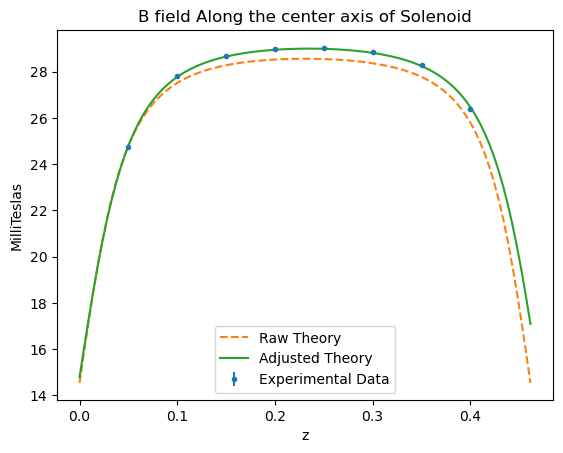

[0.05704277 0.05704277 0.05704277 0.05704277 0.05704277 0.05704277
 0.05704277 0.05704277]


In [5]:
print((7.642/200+1.4/2000)-params[0])
print( 7.27*100-params[1])
print((np.mean(long[~np.isnan(long)])/100 - 2*lip/1000)-params[2])

z = np.linspace(0,0.46155,100)
B_s = net_B(z,params[2],I,params[0],params[1],t)*1000
plt.errorbar(exp_Ls,Mean_B,yerr=SDM_B,fmt='.',label='Experimental Data')

plt.plot(z,net_B(z,np.mean(long[~np.isnan(long)])/100 - 2*lip/1000,I,(7.642/200+1.4/2000),7.27*100,1.4/1000)*1000,'--',label='Raw Theory')

plt.plot(z, B_s, label='Adjusted Theory')
plt.title('B field Along the center axis of Solenoid')
plt.ylabel('MilliTeslas')
plt.xlabel('z')
plt.legend(loc='best')
plt.show()
print(SDM_B)

3.7115780279943724
1.1382703546343316
for y=bx+a, b: 1.1034061183698431 +- 0.030749071692119715, a: 0.14075370805231427 +- 0.09615479604133816 and for y=bx, b: 1.1382703623151686 +- 0.019448513695212555


Text(0.5, 0, 'Current (amps)')

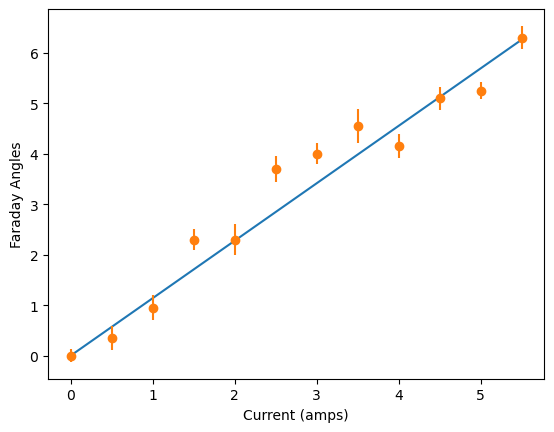

In [15]:
#DATA FOR FARADAY MEASUREMENT
dfFR = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name="Rotation2").T


def chisqfunc(m):
    model = m*I
    chisq = np.sum(((FR_vals - model)/FR_sdm)**2)
    return chisq


I = np.arange(0, 5.5+0.5, 0.5)

FR_angles = []

for i in range(len(I)):
    FR_angles.append(dfFR[4*i+5].to_numpy()[1:11])

FR_vals =  np.mean(FR_angles,axis=1)-np.mean(FR_angles[0]) #doesn't show chirality??? should fix I guess
FR_sdm = np.array([sample_standard_deviation(i)/np.sqrt(len(i)) for i in FR_angles])

#chi sqr fit

x0 = np.array([0])
deg_of_freedom = 1 #just m, number of fitting parameters
result =  opt.minimize(chisqfunc, x0)
reduced_chi = result.fun/(len(FR_vals)-1)
print(reduced_chi)
m = result.x[0]
print(m)

faraday_rotations =  np.mean(FR_angles,axis=1)-np.mean(FR_angles[0])
munc = LS_fit_ymxb(I,faraday_rotations,FR_sdm)[-1] #does same thing as scypy optimize!!!!!!!!! but with uncertainties


plt.plot(I,I*m)
plt.errorbar(I, faraday_rotations,yerr=FR_sdm, fmt='o')
plt.ylabel('Faraday Angles')
plt.xlabel('Current (amps)')

In [16]:
#getting verdet constant
def B_theory(z,I):
    t = 1.4/1000 #rough idea wire is about a mm, each wire is sperated by t thickness, diameter of wire
    R = 0.043156
    n = 740.3725
    L = 0.470039
    
    wraps = 16
    B_value = 0
    for i in range(wraps):
        B_value += solenoid(z,L,I,R+t*(i+1),n)
    return B_value

def B_avg(I,sz1,sz2):
    sL = sz2-sz1
    z_vals = np.random.uniform(sz1,sz2,5000)
    return np.mean(B_theory(z_vals,I)) #works cuz b-a/b-a in monte carlo integration

def wMean_wStd(mean_list, std_list): #weighted mean based off of the standard deviations
    sum_top = 0
    sum_bottom = 0
    for i,j in zip(mean_list,std_list):
        sum_top += i/j**2
        sum_bottom += 1/j**2
    weighted_mean = sum_top/sum_bottom
    weighted_std = (1/sum_bottom)**0.5
    return  (weighted_mean, weighted_std)


solenoid_L = np.mean(long[~np.isnan(long)])/100 - 2*lip/1000
start1 = 7.5625/39.37 #m
start2 = solenoid_L-7.6875/39.37 #m
sample_L = 115.5/1000 #m

dstart = start2-start1

ends_cyl = (sample_L - start2)/2

z1 = start1 - ends_cyl
z2 = start2 + ends_cyl

verdets = []
for i in range(1,len(I)):
    Bavg = B_avg(I[i],z1,z2)*1000 #get into mT
    B_er = ufloat(np.mean(Bavg),np.sqrt(np.std(Bavg)**2 + 0.05704**2))
    m_er = ufloat(m,munc)
    gamma  = I[i]/B_er #slightly different Bavg cuz of montecarlo randomness
    verdets.append(m_er/sample_L * gamma)

vals_verdet = [i.n for i in verdets]
sdms_verdet = [i.s for i in verdets]

final_verdet = wMean_wStd(vals_verdet,sdms_verdet) #degrees/ (mT * meters)
print(final_verdet[0]*np.pi/(180*0.001),final_verdet[1]*np.pi/(180*0.001)) #now in rad*T^-1 ^-1
print(final_verdet[0]*np.pi/(180*0.001)*(0.48),final_verdet[1]*np.pi/(180*0.001)*(0.48)) #now in rad*T^-1 ^-1

11.879719322756225 0.06202433354422374
5.702265274922988 0.029771680101227396
